In [1]:
import random
from joblib import dump, load

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

random.seed(1729)

In [2]:
df = pd.read_csv('waitlist_kidney_brazil_prepared_sensitive.csv', encoding='iso-8859-1')
df.head()

,date_registered,age_registered,dialysis_session_count,sex,race,underlying_disease,diabetes,chagas,blood_type,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,dr_00,b_00,a_00,anti_hbc,anti_hcv,hbs_ag,event,days_waiting
0,2017-06-29,67,1.0,M,Branca,other,True,False,A,0,False,False,0,1,26,44,51,3,7,heterozygous,heterozygous,heterozygous,False,False,False,waiting,392
1,2008-11-03,58,4.0,M,Branca,diabetes,False,False,A,0,False,False,0,1,24,18,35,11,0,homozygous,heterozygous,heterozygous,False,False,False,died_waiting,2066
2,2010-07-13,51,2.0,M,Branca,hypertension,True,False,O,0,False,False,64,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
3,2011-10-03,52,17.0,M,Branca,diabetes,False,False,O,0,False,True,2,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
4,2006-07-05,67,68.0,M,Parda,hypertension,True,False,A,0,False,False,0,24,68,14,27,13,15,heterozygous,heterozygous,heterozygous,False,False,False,died_waiting,194


In [3]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    df_clean = df[df['event'] == 'transplanted'].copy()
    df_clean.drop(columns=['event'], inplace=True)
    df_clean['date_registered'] = pd.to_datetime(df['date_registered']).astype(int) / (1e9 * 3600 * 24)
    df_clean['date_transplanted'] = \
        pd.to_datetime(df['date_registered']) + pd.to_timedelta(df_clean['days_waiting'], 'days')
    return df_clean


def onehot_encode(df: pd.DataFrame) -> pd.DataFrame:
    df_onehot = pd.get_dummies(
        df,
        columns=[
            'sex',
            'race',
            'underlying_disease',
            'blood_type',
            'dr_00',
            'b_00',
            'a_00'
        ],
        drop_first=True
    )
    df_onehot['race'] = df['race']
    df_onehot['sex'] = df['sex']
    return df_onehot


def train_test_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    df = df.copy()
    N = df.shape[0]
    N_train = N * 80 // 100
    df.sort_values(by='date_registered', inplace=True, ignore_index=True)
    return df.iloc[:N_train], df[N_train:]


from fairlearn.preprocessing import CorrelationRemover


def remove_correlation(df: pd.DataFrame) -> pd.DataFrame:
    sensitive_features = ['sex_M', 'race_Branca', 'race_Parda', 'race_Negra']
    correlation_remover = CorrelationRemover(sensitive_feature_ids=sensitive_features)
    meta = ['race', 'sex', 'date_registered', 'date_transplanted']
    mesa = df.drop(columns=meta) # Vide Cheal, Joe. "What is the opposite of meta?." ANLP Acuity Vol 2 (2011).
    data = correlation_remover.fit_transform(mesa)
    return pd.concat(
        [
            pd.DataFrame(data, index=mesa.index, columns=[col for col in mesa.columns if not col in sensitive_features]),
            df[meta],
            # df[sensitive_features] # Não faz sentido adicionar de volta, né?
        ],
        axis=1
    )


df_people = onehot_encode(clean(df))
df_people_train, df_people_test = train_test_split(df_people)
df_people_train_uncorrelated = remove_correlation(df_people_train)
df_people_train_uncorrelated.head()

,age_registered,dialysis_session_count,diabetes,chagas,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,anti_hbc,anti_hcv,hbs_ag,days_waiting,underlying_disease_glomerulonephritis,underlying_disease_hypertension,underlying_disease_other,underlying_disease_pyelonephritis,blood_type_AB,blood_type_B,blood_type_O,dr_00_homozygous,b_00_homozygous,a_00_homozygous,race,sex,date_registered,date_transplanted
0,-92.579005,-58.700625,-2.698233,0.0,-1.301101,-0.786908,-0.324948,-23.323957,-11.906148,-62.613581,-47.724847,-78.362652,-16.089739,-27.778388,-0.074830,-0.025542,-0.016921,-1829.826132,-0.647694,-0.918396,-1.050267,-0.081876,-0.175674,-0.492531,-1.372507,-0.150369,-0.163960,-0.356975,Amarela,M,10959.0,2004-01-21
1,-0.041522,-5.766981,0.325496,0.0,-0.337311,-0.492080,-0.088624,-12.042648,-4.173059,10.889024,-4.801405,11.216672,7.379731,7.870809,-0.019778,-0.009722,-0.003531,3727.832965,-0.188164,-0.138999,0.680715,-0.028057,-0.030686,-0.085568,-0.326738,-0.037583,-0.040446,-0.076394,Branca,F,10962.0,2012-06-20
2,7.958478,-11.766981,0.325496,0.0,0.662689,0.507920,-0.088624,52.957352,-4.173059,48.889024,18.198595,26.216672,10.379731,4.870809,-0.019778,-0.009722,-0.003531,2781.832965,-0.188164,0.861001,-0.319285,-0.028057,-0.030686,-0.085568,0.673262,-0.037583,-0.040446,-0.076394,Branca,F,10962.0,2009-11-17
3,-1.041522,-7.766981,0.325496,0.0,-0.337311,0.507920,-0.088624,-12.042648,-4.173059,11.889024,19.198595,26.216672,2.379731,-0.129191,-0.019778,-0.009722,-0.003531,729.832965,0.811836,-0.138999,-0.319285,-0.028057,-0.030686,-0.085568,0.673262,-0.037583,-0.040446,-0.076394,Branca,F,10962.0,2004-04-05
4,-6.041522,-4.766981,0.325496,0.0,0.662689,-0.492080,-0.088624,-12.042648,23.826941,13.889024,33.198595,26.216672,3.379731,4.870809,-0.019778,-0.009722,-0.003531,819.832965,0.811836,-0.138999,-0.319285,-0.028057,-0.030686,-0.085568,-0.326738,-0.037583,-0.040446,-0.076394,Branca,F,10962.0,2004-07-04


In [4]:
def sample_pairs(people: pd.DataFrame) -> pd.DataFrame:
    pairs = set()
    while len(pairs) < 200000:
        a = random.randint(1, people.shape[0] - 1)
        b = random.randint(max(0, a - 1000), a-1)
        pairs.add((a, b))
    a = [i for (i, _) in pairs]
    b = [i for (_, i) in pairs]

    df_a = people.iloc[a]
    df_a.columns = df_a.columns + '_a'
    df_b = people.iloc[b]
    df_b.columns = df_b.columns + '_b'

    df_a.index = df_b.index = range(len(pairs))

    df_pairs = pd.concat((df_a, df_b), axis=1)
    df_pairs['transplanted_first'] = \
        df_pairs['date_transplanted_a'] < df_pairs['date_transplanted_b']
    return df_pairs


df_pairs = sample_pairs(df_people_train_uncorrelated)
df_pairs.head()

,age_registered_a,dialysis_session_count_a,diabetes_a,chagas_a,transfusion_count_a,gestation_a,prior_transplant_a,c_pra_a,hla_a1_a,hla_a2_a,hla_b1_a,hla_b2_a,hla_dr1_a,hla_dr2_a,anti_hbc_a,anti_hcv_a,hbs_ag_a,days_waiting_a,underlying_disease_glomerulonephritis_a,underlying_disease_hypertension_a,underlying_disease_other_a,underlying_disease_pyelonephritis_a,blood_type_AB_a,blood_type_B_a,blood_type_O_a,dr_00_homozygous_a,b_00_homozygous_a,a_00_homozygous_a,race_a,sex_a,date_registered_a,date_transplanted_a,age_registered_b,dialysis_session_count_b,diabetes_b,chagas_b,transfusion_count_b,gestation_b,prior_transplant_b,c_pra_b,hla_a1_b,hla_a2_b,hla_b1_b,hla_b2_b,hla_dr1_b,hla_dr2_b,anti_hbc_b,anti_hcv_b,hbs_ag_b,days_waiting_b,underlying_disease_glomerulonephritis_b,underlying_disease_hypertension_b,underlying_disease_other_b,underlying_disease_pyelonephritis_b,blood_type_AB_b,blood_type_B_b,blood_type_O_b,dr_00_homozygous_b,b_00_homozygous_b,a_00_homozygous_b,race_b,sex_b,date_registered_b,date_transplanted_b,transplanted_first
0,15.292753,12.416151,0.222175,0.0,-0.330989,0.016731,-0.101278,-3.688702,-6.365861,-21.650627,11.134973,1.036748,5.485917,2.752868,-0.021678,-0.009784,-0.005444,-228.189853,0.807500,-0.232678,-0.327444,-0.025203,-0.037484,0.884518,-0.407581,-0.040625,-0.050848,-0.095291,Branca,M,13629.0,2009-03-26,6.958478,-9.766981,0.325496,0.0,-0.337311,-0.492080,-0.088624,-12.042648,-5.173059,-17.110976,15.198595,13.216672,3.379731,5.870809,-0.019778,-0.009722,-0.003531,510.832965,-0.188164,-0.138999,0.680715,-0.028057,-0.030686,-0.085568,0.673262,-0.037583,-0.040446,-0.076394,Branca,F,13371.0,2010-04-04,True
1,14.292753,-9.583849,-0.777825,0.0,-0.330989,0.016731,-0.101278,-3.688702,-6.365861,5.349373,-9.865027,6.036748,7.485917,4.752868,-0.021678,-0.009784,-0.005444,-81.189853,-0.192500,-0.232678,-0.327444,-0.025203,-0.037484,-0.115482,-0.407581,-0.040625,-0.050848,-0.095291,Branca,M,14463.0,2011-12-02,1.658612,-5.215401,0.811616,0.0,-0.061731,0.224507,-0.021659,3.041404,-4.198017,-7.387131,-2.239050,24.749844,9.031862,11.636890,-0.015403,0.001284,-0.001891,916.349716,-0.007280,-0.154136,0.976074,-0.003042,-0.032853,0.925323,-0.122814,-0.011853,-0.013385,-0.036375,Negra,M,14194.0,2012-02-22,True
2,-1.707247,6.416151,0.222175,0.0,-0.330989,0.016731,-0.101278,-3.688702,-6.365861,43.349373,-9.865027,14.036748,4.485917,2.752868,-0.021678,-0.009784,-0.005444,-638.189853,-0.192500,-0.232678,0.672556,-0.025203,-0.037484,-0.115482,0.592419,-0.040625,-0.050848,-0.095291,Branca,M,15614.0,2013-07-18,-7.041522,-2.766981,0.325496,0.0,-0.337311,-0.492080,-0.088624,-12.042648,-4.173059,-17.110976,-4.801405,-15.783328,9.379731,4.870809,-0.019778,-0.009722,-0.003531,-790.167035,-0.188164,-0.138999,0.680715,-0.028057,-0.030686,-0.085568,0.673262,-0.037583,-0.040446,-0.076394,Branca,F,15562.0,2012-09-10,False
3,-2.707247,-10.583849,0.222175,0.0,-0.330989,0.016731,-0.101278,-3.688702,2.634139,0.349373,-16.865027,-20.963252,-1.514083,5.752868,-0.021678,-0.009784,-0.005444,1473.810147,0.807500,-0.232678,-0.327444,-0.025203,-0.037484,-0.115482,-0.407581,-0.040625,-0.050848,-0.095291,Branca,M,13063.0,2012-05-05,30.060822,3.766260,0.487308,0.0,-0.235652,0.141106,-0.055485,0.352956,-5.351047,-17.223325,1.958559,8.516540,7.283020,5.870974,-0.002476,-0.004117,-0.003849,93.981865,-0.124324,0.795105,-0.175883,-0.007590,-0.026057,-0.096486,0.735418,-0.025838,-0.031859,-0.071885,Parda,M,12951.0,2007-04-16,False
4,33.060822,-6.233740,0.487308,0.0,-0.235652,0.141106,-0.055485,0.352956,-6.351047,54.776675,25.958559,-11.483460,4.283020,5.870974,-0.002476,-0.004117,-0.003849,698.981865,0.875676,-0.204895,-0.175883,-0.007590,-0.026057,-0.096486,0.735418,-0.025838,-0.031859,0.928115,Parda,M,11248.0,2004-04-13,14.060822,-10.233740,0.487308,0.0,-0.235652,0.141106,-0.055485,0.352956,-5.351047,12.776675,41.958559,-11.483460,9.283020,7.870974,-0.002476,-0.004117,-0.003849,206.981865,-0.124324,0.795105,-0.175883,-0.007590,-0.026057,-0.096486,-0.264582,-0.0258

In [5]:
def X_y_meta_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    target = 'transplanted_first'
    _meta = ['days_waiting_a', 'days_waiting_b', 'date_transplanted_a', 'date_transplanted_b', 'race_a', 'race_b', 'sex_a', 'sex_b']
    return df.drop(columns=[target, *_meta]), df[target], df[_meta]


X, y, meta = X_y_meta_split(df_pairs)

In [6]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(
    n_estimators=1500,
    min_samples_split=2,
    max_features='sqrt',
    random_state=1729,
    n_jobs=-1
)
classifier.fit(X, y)

RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=1729)

In [9]:
df_pairs_test = sample_pairs(remove_correlation(df_people_test))
X_test, y_test, _ = X_y_meta_split(df_pairs_test)
y_pred = classifier.predict(X_test)

/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


array([[<Axes: title={'center': 'accuracy'}, xlabel='race_a'>,
        <Axes: title={'center': 'precision'}, xlabel='race_a'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race_a'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race_a'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race_a'>,
        <Axes: title={'center': 'count'}, xlabel='race_a'>],
       [<Axes: xlabel='race_a'>, <Axes: xlabel='race_a'>,
        <Axes: xlabel='race_a'>]], dtype=object)

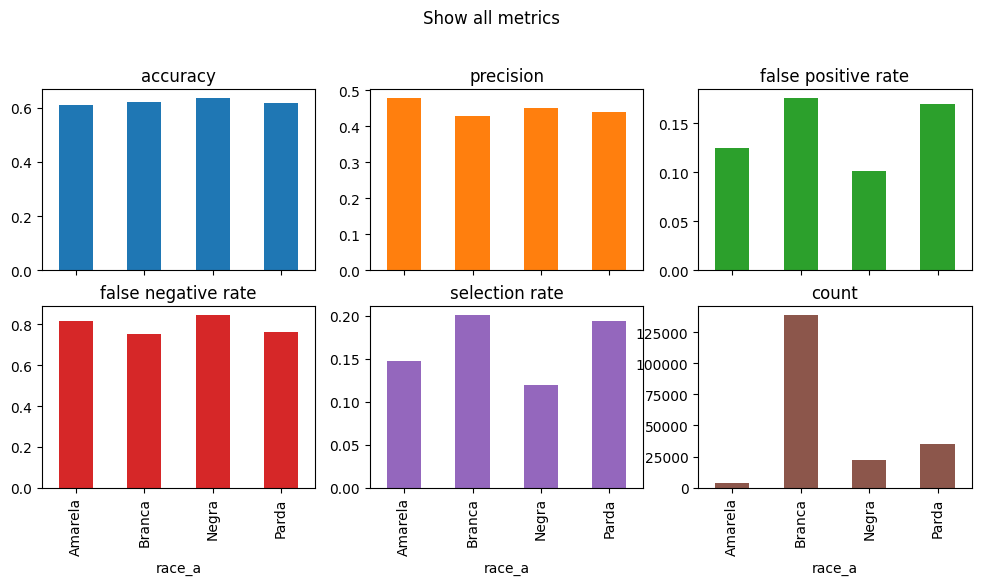

In [10]:
from sklearn.metrics import accuracy_score, precision_score
from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate, selection_rate, count

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=df_pairs_test['race_a']
)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [11]:
def metric_thingamagick(X, y1, y2) -> float:
    return abs(y2[(~X) & y1].mean() - y_pred[X & y1].mean()) / 2 + \
           abs(y2[(~X) & (~y1)].mean() - y2[X & (~y1)].mean()) / 2

In [12]:
(
    metric_thingamagick(df_pairs_test['sex_a'] == 'M', y_test, y_pred),
    metric_thingamagick(df_pairs_test['sex_a'] == 'M', y_pred, y_test),
    metric_thingamagick(df_pairs_test['race_a'] == 'Branca', y_test, y_pred),
    metric_thingamagick(df_pairs_test['race_a'] == 'Branca', y_pred, y_test)
)

(0.06971465151428774,
 0.2768862328126869,
 0.038662763181961254,
 0.28317931784775413)